In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

In [2]:
class Data:
    def __init__(self, x_dim):
        self.xa, self.xb, self.x_grid_size = x_dim
        self.nx = self.x_grid_size + 1
        self.dx = (self.xb - self.xa) / self.x_grid_size
        self.x = np.linspace(self.xa, self.xb, self.nx)
        
    def get_x(self):
        return self.x

        
class NumericalSolver(Data):
    def __init__(self, x_dim, nu, cfl):
        super().__init__(x_dim)
        self.nu = nu
        self.cfl = cfl
        self.n_iters = 0
    
    def initial_solution(self):
        return np.sin(pi * x)
    
    def boundary_condition(self, u):
        u[0] = 0
        u[-1] = 0
        return u
    
    def timestep(self, u):
        sn_max = np.max(np.abs(u))
        dt_cfl = self.cfl * self.dx / sn_max
        dt_diff = np.square(self.dx) / (2*self.nu)
        dt = np.min([dt_cfl, dt_diff])
        return dt
    
    def calculate_r(self, u):
        # ut + uux = nu*uxx
        # ut = -uux + nu*uxx = r
        
        # uxx(i) = (u(i+1) + u(i-1) - 2*u(i)) / (dx^2)
        # i = 1,nx-1
        uxx = np.zeros(self.nx)
        uxx[1:-1] = (u[2:] + u[:-2] - 2*u[1:-1]) / np.square(self.dx)
        
        # i = 0
        # uux(0) = u(0) * (u(1) - u(0)) / dx
        uux = np.zeros(self.nx)
        uux[0] = u[0] * (u[1] - u[0]) / self.dx
        # i = 1,nx-1
        # uux(i) = u(i) * (u(i+1) - u(i-1)) / (2*self.dx)
        # i = 1,nx-1
        uux[1:-1] = u[1:-1] * (u[2:] - u[:-2]) / (2*self.dx)
        # i = nx
        # uux(nx) = u(nx) * (u(nx) - u(nx-1)) / dx
        uux[-1] = u[-1] * (u[-1] - u[-2]) / self.dx
        
        r = -uux + self.nu*uxx
        return r
    
    def rk4_method(self, u, dt):
        rn = self.calculate_r(u)
        # step 1
        u_1 = u + 0.5*dt*rn
        r1 = self.calculate_r(u_1)
        # step 2
        u_2 = u + 0.5*dt*r1
        r2 = self.calculate_r(u_2)
        # step 3
        u_3 = u + dt*r2
        r3 = self.calculate_r(u_3)
        # step 4
        u_new = u + (rn + 2.0*r1 + 2.0*r2 + r3)*dt/6
        return u_new
    
    def solve(self, tf):
        u_old = self.initial_solution()
        t = 0        
        
        while t <= tf:
            self.n_iters += 1
            dt = self.timestep(u_old)
            t += dt

            u_new = self.rk4_method(u_old, dt)
            u_new = self.boundary_condition(u_new)
            u_old = np.copy(u_new)

        return u_new
    
    
class ExactSolver(Data):
    fn = lambda self, n: 2 * self.f0 * np.cos(n*pi*self.x)
    # Trapezoid Rule
    # I(a, b) = 0.5 * sum(f(i) + f(i+1)) * dx
    # i = 0,nx-1
    calculate_integral = lambda self, f: 0.5 * np.sum([f[:-1] + f[1:]]) * self.dx
    
    def __init__(self, x_dim, nu):
        super().__init__(x_dim)
        self.nu = nu
        self.f0 = np.exp(-1/(2*pi*self.nu) * (1 - np.cos(pi*self.x)))
        
    def solve(self, t, N=100):
        numerator = 0
        denominator = self.calculate_integral(self.f0)
        for i in range(1, N+1):
            ai = self.calculate_integral(self.fn(i))
            numerator += ai * np.exp(-np.square(pi*i)*self.nu*t) * i * np.sin(i*pi*self.x)
            denominator +=  ai * np.exp(-np.square(pi*i)*self.nu*t) * np.cos(i*pi*self.x)
        numerator *= 2*pi*self.nu
        u_t = numerator / denominator
        return u_t
    

def compare_and_save(x, u_exact, u_appr, tf, file_name):
    plt.plot(x, u_exact, color='green', linestyle='dashed', label='exact solution')
    plt.plot(x, u_appr, color='red', linestyle='dotted', label='RK4 method')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'Solution at t = {tf}')
    plt.savefig(file_name)
    np.savez(file_name, u_exact=u_exact, u_appr=u_appr)

In [3]:
xa, xb, x_grid_size = (0, 1, 200)
x_dim = (xa, xb, x_grid_size)
nu = 0.01
cfl = 0.25

In [4]:
data = Data(x_dim)
x = data.get_x()
np.save('array', x)

In [5]:
numerical_solver = NumericalSolver(x_dim, nu, cfl)
exact_solver = ExactSolver(x_dim, nu)

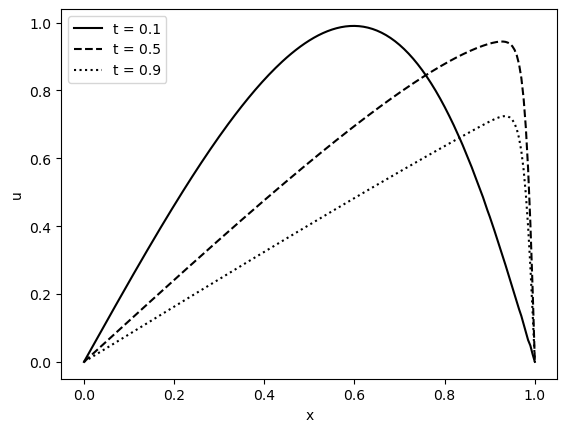

In [6]:
t = [0.1, 0.5, 0.9]
line = ['solid', 'dashed', 'dotted']
ut = []
for i in range(len(t)):
    u = exact_solver.solve(t[i])
    plt.plot(x, u, label=f't = {t[i]}', linestyle=line[i], color='black')
    ut.append(u)
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.savefig('exact_solution_at_01_05_09')
np.save('exact_solution_at_01_05_09', np.array(ut))

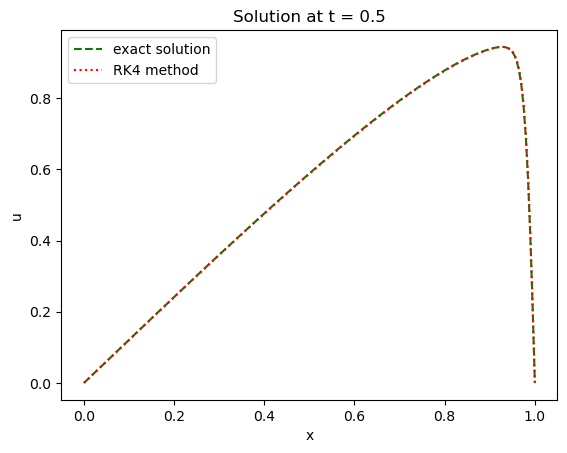

In [7]:
tf = 0.5
file_name = 'u_at_05'
u_05_appr = numerical_solver.solve(tf)
u_05_exact = exact_solver.solve(tf)
compare_and_save(x, u_05_exact, u_05_appr, tf, file_name)

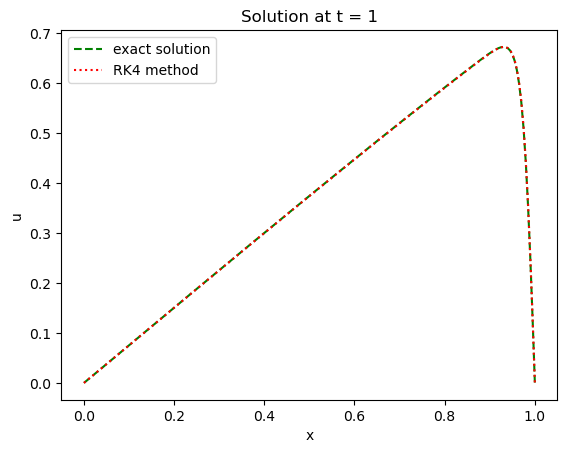

In [8]:
tf = 1
file_name = 'u_at_1'
u_1_appr = numerical_solver.solve(tf)
u_1_exact = exact_solver.solve(tf)
compare_and_save(x, u_1_exact, u_1_appr, tf, file_name)